## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from nltk.stem import WordNetLemmatizer

## Read in saved data and prepare X, y, train_test_split

- stratified on y though split is almost even

In [5]:
df = pd.read_csv('./data/combinded_condensed.csv')

df.head()

,subreddit,permalink,selftext,title
0,LifeProTips,/r/LifeProTips/comments/u9wftb/lpt_dont_drive_...,NaN,LPT: Don’t drive yourself mad trying to “live ...
1,LifeProTips,/r/LifeProTips/comments/u9wdtc/lpt_request_it/,"Whenever you start a new job, let them know yo...",LPT: Request it.
2,LifeProTips,/r/LifeProTips/comments/u9vhmd/lpt_do_not_list...,Unless you absolutely know what tf you're doin...,"LPT: DO NOT list a minor as the POD ""Payable O..."
3,LifeProTips,/r/LifeProTips/comments/u9vgku/lpt_the_perfect...,Don’t you just love cupcakes but hate having t...,LPT: The perfect way to eat a cupcake is to ge...
4,LifeProTips,/r/LifeProTips/comments/u9vf15/lpt_if_youre_ba...,Thank me later. Rest In Peace bananas. :(,LPT: If you’re baking something and it’s takin...


In [6]:
# starting just using the title column for x
X = df['title']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1357)

cv = CountVectorizer()

cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

## Establish Baseline

- not 50/50 due to some duplicate posts being removed
- just guessing majority class would give us accuracy of 50.3%

In [ ]:
y_train.value_counts(normalize=True)

LifeProTips             0.503451
UnethicalLifeProTips    0.496549
Name: subreddit, dtype: float64

In [7]:
y_test.value_counts(normalize=True)

LifeProTips             0.503653
UnethicalLifeProTips    0.496347
Name: subreddit, dtype: float64

## First model

- with a simple logistic regression accuracy of 99.4% is achieved. only failing on 13 posts
- included some words that made modeling almost trivial
    - both subreddits require that lpt and ulpt be in the title
    - they are the 4th and 5th mose common words
  

In [8]:
lr = LogisticRegression(max_iter=10_000, n_jobs=-1)
lr.fit(X_train_cv, y_train)
lr.score(X_test_cv, y_test)

0.994724025974026

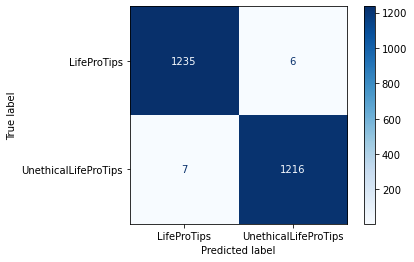

In [9]:
ConfusionMatrixDisplay.from_estimator(lr,X_test_cv, y_test, cmap='Blues');

In [10]:
preds = lr.predict(X_test_cv)

In [11]:
print(classification_report(y_test, preds, digits=5))

                      precision    recall  f1-score   support

         LifeProTips    0.99436   0.99517   0.99476      1241
UnethicalLifeProTips    0.99509   0.99428   0.99468      1223

            accuracy                        0.99472      2464
           macro avg    0.99473   0.99472   0.99472      2464
        weighted avg    0.99472   0.99472   0.99472      2464



In [104]:
pd.DataFrame(X_train_cv.A, columns=cv.get_feature_names_out()).sum().sort_values(ascending=False).head(5)

to      5266
you     4706
the     3947
lpt     3689
ulpt    3557
dtype: int64

In [11]:
# instanciate dataframe to save parameters of lr gridsearches and their accuracy
results = pd.DataFrame()

## LogisticRegression

- starting to save parameters and accuracy of gridsearches into dataframe then save to 'results.csv'
- best was accuracy of .832792 accuracy
    - without 'english' stopwords
    - (1,2) ngram range
    - strip accents made no difference
    - min_df favored lowest provided value every time 0

In [9]:
stops = ['ulpt', 'lpt']
my_stop_words = ENGLISH_STOP_WORDS.union(stops)

In [44]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=10_000, n_jobs=-1, random_state=1357))
])

In [45]:
grid = {
    "cv__min_df": [.000001,.00001, .0001, .001, .01, .1],
    "cv__stop_words": [stops],
    'cv__ngram_range': [(1,2), (1,3)],
    'cv__strip_accents': ['ascii','unicode']
}
gs = GridSearchCV(pipe, param_grid=grid, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=10000,
                                                           n_jobs=-1,
                                                           random_state=1357))]),
             n_jobs=-1,
             param_grid={'cv__min_df': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'cv__ngram_range': [(1, 2), (1, 3)],
                         'cv__stop_words': [['ulpt', 'lpt']],
                         'cv__strip_accents': ['ascii', 'unicode']})

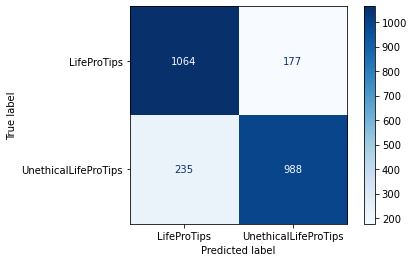

In [46]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Blues');

**Below is to save the:**

    1. accuracy score
    2. parameters searched across
    3. parameters that contributed to the highest accuracy score
    
*each row in the results data frame is one completed grid search*

In [220]:
best = gs.best_params_
best['accuracy'] = gs.best_estimator_.score(X_test, y_test)
tested_params = {key.replace('__','_'):gs.param_grid[key] for key in gs.param_grid}
best.update(tested_params)
best.update(pipe.named_steps)
best = {key:[best[key]] for key in best}

In [221]:
results = pd.concat([pd.DataFrame(best), results], axis=0, ignore_index=True)

In [222]:
results

,cv__min_df,cv__ngram_range,cv__stop_words,cv__strip_accents,accuracy,cv_min_df,cv_stop_words,cv_ngram_range,cv_strip_accents,cv,lr,knn
0,0.000001,"(1, 2)","[ulpt, lpt]",unicode,0.832792,"[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]","[[ulpt, lpt]]","[(1, 2), (1, 3)]","[ascii, unicode]",CountVectorizer(),"LogisticRegression(max_iter=10000, n_jobs=-1, ...",NaN
1,100.000000,"(1, 3)","[ulpt, lpt]",unicode,0.755276,"[0, 5, 10, 100]","[[ulpt, lpt], (bill, becoming, each, i, de, so...","[(1, 2), (1, 3)]","[ascii, unicode]",CountVectorizer(),NaN,KNeighborsClassifier()
2,0.000000,"(1, 2)","[ulpt, lpt]",unicode,0.832792,"[0, 1]","[[ulpt, lpt]]","[(1, 2), (1, 3)]","[ascii, unicode]",CountVectorizer(),"LogisticRegression(max_iter=10000, n_jobs=-1, ...",NaN
3,1.000000,"(1, 2)","[ulpt, lpt]",unicode,0.832792,"[1, 5, 10]","[[ulpt, lpt]]","[(1, 2), (1, 3)]","[ascii, unicode]",CountVectorizer(),"LogisticRegression(max_iter=10000, n_jobs=-1, ...",NaN
4,1.000000,"(1, 2)","[ulpt, lpt]",NaN,0.832792,"[1, 5, 10]","[[ulpt, lpt], (bill, becoming, each, i, de, so...","[(1, 2), (1, 3)]",NaN,CountVectorizer(),"LogisticRegression(max_iter=10000, n_jobs=-1, ...",NaN
5,1.000000,"(1, 3)","[ulpt, lpt]",NaN,0.831981,"[1, 5, 10]","[[ulpt, lpt]]","[(1, 1), (2, 2), (1, 3)]",NaN,CountVectorizer(),"LogisticRegression(max_iter=10000, n_jobs=-1, ...",NaN
6,10.000000,"(1, 2)",english,NaN,0.993506,"[1, 5, 10]","[[ulpt, lpt], english]","[(1, 2), (3, 3), (2, 3)]",NaN,CountVectorizer(),"LogisticRegression(max_iter=10000, n_jobs=-1, ...",NaN
7,1.000000,"(1, 2)","[ulpt, lpt]",NaN,0.832792,"[1, 5, 10]","[[ulpt, lpt]]","[(1, 2), (3, 3), (2, 3)]",NaN,CountVectorizer(),"LogisticRegression(max_iter=10000, n_jobs=-1, ...",NaN


## KNN models

- using more parameters per search since it tends to run faster than logistic regression

In [41]:
knn_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [42]:
knn_grid = {
    'knn__n_neighbors': [1,5,10,20],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1,2]
}

knn_gs = GridSearchCV(knn_pipe, param_grid=knn_grid, n_jobs=-1)
knn_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cv__min_df': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'cv__ngram_range': [(1, 2), (1, 3)],
                         'cv__stop_words': [['ulpt', 'lpt'],
                                            frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                         

In [229]:
best = knn_gs.best_params_
best['accuracy'] = knn_gs.best_estimator_.score(X_test, y_test)
tested_params = {key.replace('__','_'):knn_gs.param_grid[key] for key in knn_gs.param_grid}
best.update(tested_params)
best.update(knn_pipe.named_steps)
best = {key:[best[key]] for key in best}

In [230]:
results = pd.concat([pd.DataFrame(best), results], axis=0, ignore_index=True)

In [231]:
results

,cv__min_df,cv__ngram_range,cv__stop_words,cv__strip_accents,knn__n_neighbors,knn__p,knn__weights,accuracy,cv_min_df,cv_stop_words,cv_ngram_range,cv_strip_accents,knn_n_neighbors,knn_weights,knn_p,cv,knn,lr
0,0.100000,"(1, 2)","[ulpt, lpt]",ascii,20.0,1.0,uniform,0.767857,"[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]","[[ulpt, lpt], (bill, becoming, each, i, de, so...","[(1, 2), (1, 3)]","[ascii, unicode]","[1, 5, 10, 20]","[uniform, distance]","[1, 2]",CountVectorizer(),KNeighborsClassifier(),NaN
1,0.100000,"(1, 2)","(bill, becoming, each, i, de, sometimes, he, t...",ascii,NaN,NaN,NaN,0.754464,"[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]","[[ulpt, lpt], (bill, becoming, each, i, de, so...","[(1, 2), (1, 3)]","[ascii, unicode]",NaN,NaN,NaN,CountVectorizer(),KNeighborsClassifier(),NaN
2,0.000001,"(1, 2)","[ulpt, lpt]",unicode,NaN,NaN,NaN,0.832792,"[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]","[[ulpt, lpt]]","[(1, 2), (1, 3)]","[ascii, unicode]",NaN,NaN,NaN,CountVectorizer(),NaN,"LogisticRegression(max_iter=10000, n_jobs=-1, ..."
3,100.000000,"(1, 3)","[ulpt, lpt]",unicode,NaN,NaN,NaN,0.755276,"[0, 5, 10, 100]","[[ulpt, lpt], (bill, becoming, each, i, de, so...","[(1, 2), (1, 3)]","[ascii, unicode]",NaN,NaN,NaN,CountVectorizer(),KNeighborsClassifier(),NaN
4,0.000000,"(1, 2)","[ulpt, lpt]",unicode,NaN,NaN,NaN,0.832792,"[0, 1]","[[ulpt, lpt]]","[(1, 2), (1, 3)]","[ascii, unicode]",NaN,NaN,NaN,CountVectorizer(),NaN,"LogisticRegression(max_iter=10000, n_jobs=-1, ..."
5,1.000000,"(1, 2)","[ulpt, lpt]",unicode,NaN,NaN,NaN,0.832792,"[1, 5, 10]","[[ulpt, lpt]]","[(1, 2), (1, 3)]","[ascii, unicode]",NaN,NaN,NaN,CountVectorizer(),NaN,"LogisticRegression(max_iter=10000, n_jobs=-1, ..."
6,1.000000,"(1, 2)","[ulpt, lpt]",NaN,NaN,NaN,NaN,0.832792,"[1, 5, 10]","[[ulpt, lpt], (bill, becoming, each, i, de, so...","[(1, 2), (1, 3)]",NaN,NaN,NaN,NaN,CountVectorizer(),NaN,"LogisticRegression(max_iter=10000, n_jobs=-1, ..."
7,1.000000,"(1, 3)","[ulpt, lpt]",NaN,NaN,NaN,NaN,0.831981,"[1, 5, 10]","[[ulpt, lpt]]","[(1, 1), (2, 2), (1, 3)]",NaN,NaN,NaN,NaN,CountVectorizer(),NaN,"LogisticRegression(max_iter=10000, n_jobs=-1, ..."
8,10.000000,"(1, 2)",english,NaN,NaN,NaN,NaN,0.993506,"[1, 5, 10]","[[ulpt, lpt], english]","[(1, 2), (3, 3), (2, 3)]",NaN,NaN,NaN,NaN,CountVectorizer(),NaN,"LogisticRegression(max_iter=10000, n_jobs=-1, ..."
9,1.000000,"(1, 2)","[ulpt, lpt]",NaN,NaN,NaN,NaN,0.832792,"[1, 5, 10]","[[ulpt, lpt]]","[(1, 2), (3, 3), (2, 3)]",NaN,NaN,NaN,NaN,CountVectorizer(),NaN,"LogisticRegression(max_iter=10000, n_jobs=-1, ..."


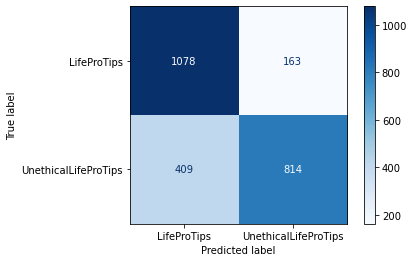

In [43]:
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test, y_test, cmap='Blues');

## Trees

- ExtraTreesClassifier


In [19]:
etc_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('etc', ExtraTreesClassifier(rarandom_state=_state=1357))
])

In [28]:
etc_grid = {
    "cv__stop_words": [stops],
    'cv__ngram_range': [(1,1)],
    'cv__strip_accents': ['ascii'],
    'etc__min_samples_split': [2, 5, 10, 50],
    'etc__n_estimators': [100, 150, 200],
    'etc__min_samples_leaf': [1, 5, 20],
    'etc__criterion': ['gini', 'entropy']
}
etc_gs = GridSearchCV(etc_pipe, param_grid=etc_grid, n_jobs=-1)
etc_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('etc', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'cv__ngram_range': [(1, 1)],
                         'cv__stop_words': [['ulpt', 'lpt']],
                         'cv__strip_accents': ['ascii'],
                         'etc__criterion': ['gini', 'entropy'],
                         'etc__min_samples_leaf': [1, 5, 20],
                         'etc__min_samples_split': [2, 5, 10, 50],
                         'etc__n_estimators': [100, 150, 200]})

In [29]:
best = etc_gs.best_params_
best['accuracy'] = etc_gs.best_estimator_.score(X_test, y_test)
tested_params = {key.replace('__','_'):etc_gs.param_grid[key] for key in etc_gs.param_grid}
best.update(tested_params)
best.update(etc_pipe.named_steps)
best = {key:[best[key]] for key in best}

In [30]:
results = pd.concat([pd.DataFrame(best), results], axis=0, ignore_index=True)

In [31]:
results

,cv__ngram_range,cv__stop_words,cv__strip_accents,etc__criterion,etc__min_samples_leaf,etc__min_samples_split,etc__n_estimators,accuracy,cv_stop_words,cv_ngram_range,...,etc,rfc__criterion,rfc__min_samples_leaf,rfc__min_samples_split,rfc__n_estimators,rfc_min_samples_split,rfc_n_estimators,rfc_min_samples_leaf,rfc_criterion,rfc
0,"(1, 1)","[ulpt, lpt]",ascii,gini,1.0,10.0,150.0,0.817776,"[[ulpt, lpt]]","[(1, 1)]",...,ExtraTreesClassifier(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(1, 1)","[ulpt, lpt]",unicode,NaN,NaN,NaN,NaN,0.812906,"[[ulpt, lpt]]","[(1, 1)]",...,NaN,entropy,1.0,5.0,100.0,"[2, 5, 10, 50]","[100, 150, 200]","[1, 5, 20]","[gini, entropy]",RandomForestClassifier()
2,"(1, 1)","[ulpt, lpt]",ascii,NaN,1.0,5.0,100.0,0.819399,"[[ulpt, lpt]]","[(1, 1)]",...,ExtraTreesClassifier(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(1, 1)","[ulpt, lpt]",unicode,NaN,NaN,NaN,NaN,0.815747,"[[ulpt, lpt]]","[(1, 1)]",...,NaN,NaN,1.0,5.0,150.0,"[2, 5, 10, 50]","[100, 150, 200]","[1, 5, 20]",NaN,RandomForestClassifier()
4,"(1, 1)","[ulpt, lpt]",unicode,NaN,NaN,NaN,NaN,0.811282,"[[ulpt, lpt], (should, must, around, by, other...","[(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RandomForestClassifier()


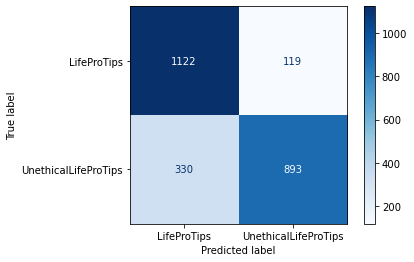

In [40]:
ConfusionMatrixDisplay.from_estimator(etc_gs, X_test, y_test, cmap='Blues');

In [7]:
rfc_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('rfc', RandomForestClassifier(random_state=1357))
])

In [24]:
rfc_grid = {
    "cv__stop_words": [stops],
    'cv__ngram_range': [(1,1)],
    'cv__strip_accents': ['unicode'],
    'rfc__min_samples_split': [2, 5, 10, 50],
    'rfc__n_estimators': [100, 150, 200],
    'rfc__min_samples_leaf': [1, 5, 20],
    'rfc__criterion': ['gini', 'entropy']
}
rfc_gs = GridSearchCV(rfc_pipe, param_grid=rfc_grid, n_jobs=-1)
rfc_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cv__ngram_range': [(1, 1)],
                         'cv__stop_words': [['ulpt', 'lpt']],
                         'cv__strip_accents': ['unicode'],
                         'rfc__criterion': ['gini', 'entropy'],
                         'rfc__min_samples_leaf': [1, 5, 20],
                         'rfc__min_samples_split': [2, 5, 10, 50],
                         'rfc__n_estimators': [100, 150, 200]})

In [25]:
best = rfc_gs.best_params_
best['accuracy'] = rfc_gs.best_estimator_.score(X_test, y_test)
tested_params = {key.replace('__','_'):rfc_gs.param_grid[key] for key in rfc_gs.param_grid}
best.update(tested_params)
best.update(rfc_pipe.named_steps)
best = {key:[best[key]] for key in best}

In [26]:
results = pd.concat([pd.DataFrame(best), results], axis=0, ignore_index=True)

In [27]:
results.sort_values(by = 'accuracy', ascending=False)

,cv__ngram_range,cv__stop_words,cv__strip_accents,rfc__criterion,rfc__min_samples_leaf,rfc__min_samples_split,rfc__n_estimators,accuracy,cv_stop_words,cv_ngram_range,...,rfc_criterion,cv,rfc,etc__min_samples_leaf,etc__min_samples_split,etc__n_estimators,etc_min_samples_split,etc_n_estimators,etc_min_samples_leaf,etc
1,"(1, 1)","[ulpt, lpt]",ascii,NaN,NaN,NaN,NaN,0.819399,"[[ulpt, lpt]]","[(1, 1)]",...,NaN,CountVectorizer(),NaN,1.0,5.0,100.0,"[2, 5, 10, 50]","[100, 150, 200]","[1, 5, 20]",ExtraTreesClassifier()
2,"(1, 1)","[ulpt, lpt]",unicode,NaN,1.0,5.0,150.0,0.815747,"[[ulpt, lpt]]","[(1, 1)]",...,NaN,CountVectorizer(),RandomForestClassifier(),NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,"(1, 1)","[ulpt, lpt]",unicode,entropy,1.0,5.0,100.0,0.812906,"[[ulpt, lpt]]","[(1, 1)]",...,"[gini, entropy]",CountVectorizer(),RandomForestClassifier(),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(1, 1)","[ulpt, lpt]",unicode,NaN,NaN,NaN,NaN,0.811282,"[[ulpt, lpt], (should, must, around, by, other...","[(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]",...,NaN,CountVectorizer(),RandomForestClassifier(),NaN,NaN,NaN,NaN,NaN,NaN,NaN


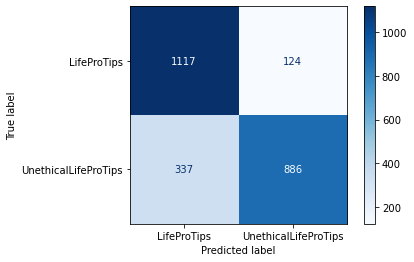

In [37]:
ConfusionMatrixDisplay.from_estimator(rfc_gs, X_test, y_test, cmap='Blues');

# Voting Classifier

 - unsuccessful in achieving a score higher than just lr. seems to be a cap?


In [62]:
# using integer weights since it auto scales to where sum of weights is 1
vc = VotingClassifier(
    [
        ('lr', gs.best_estimator_),
        ('knn', knn_gs.best_estimator_),
        ('rfc', rfc_gs.best_estimator_),
        ('ect', etc_gs.best_estimator_)
    ],
    n_jobs=-1,
    weights = [8,3,5,9]
)


vc.fit(X_train, y_train)
vc.score(X_test,y_test)

0.8193993506493507

## What are the models getting wrong?

Identifying posts that models have been getting wrong to attempt to identify commonalities

In [23]:
# lr
gs.best_estimator_.predict(X_test)
np.where(y_test != gs.best_estimator_.predict(X_test),1,0)

NameError: name 'gs' is not defined

In [67]:
# knn
knn_gs.best_estimator_.predict(X_test)
np.where(y_test != knn_gs.best_estimator_.predict(X_test),1,0)

array([0, 0, 0, ..., 0, 0, 1])

In [68]:
# random forest
rfc_gs.best_estimator_.predict(X_test)
np.where(y_test != rfc_gs.best_estimator_.predict(X_test),1,0)

array([0, 0, 0, ..., 0, 1, 1])

In [65]:
# extra trees
etc_gs.best_estimator_.predict(X_test)
np.where(y_test != etc_gs.best_estimator_.predict(X_test),1,0)

array([0, 0, 0, ..., 0, 1, 1])

In [71]:
test_predictions = pd.DataFrame(y_test)
test_predictions['lr'] = np.where(y_test != gs.best_estimator_.predict(X_test),1,0)
test_predictions['knn'] = np.where(y_test != knn_gs.best_estimator_.predict(X_test),1,0)
test_predictions['rfc'] = np.where(y_test != rfc_gs.best_estimator_.predict(X_test),1,0)
test_predictions['etc'] = np.where(y_test != etc_gs.best_estimator_.predict(X_test),1,0)

In [87]:
test_predictions[test_predictions[['lr','knn','rfc','etc']].T.sum() != 0]

,subreddit,lr,knn,rfc,etc
3009,LifeProTips,1,0,0,1
5280,UnethicalLifeProTips,0,1,1,1
5240,UnethicalLifeProTips,1,1,1,1
75,LifeProTips,1,1,1,1
7083,UnethicalLifeProTips,1,1,1,1
...,...,...,...,...,...
7345,UnethicalLifeProTips,0,1,1,1
7163,UnethicalLifeProTips,1,1,1,1
421,LifeProTips,0,1,1,1
8306,UnethicalLifeProTips,1,0,1,1


In [127]:
wrong = pd.concat([pd.DataFrame(X_test), test_predictions], axis=1)

In [99]:
list(wrong[wrong[['lr','knn','rfc','etc']].T.sum() ==4]['title'])

["ULPT: If you miss an email, ask which email the person sent it to, then just claim you don't check that email",
 'LPT Request: What should I look for when visiting a house or apartment that I am looking to rent?',
 'ULPT: If you live with roommates and hate doing chores, only ever do them when everyone is around. That way everyone will see you doing them and will think you’re a good roommate and the rest of the time you can slack off.',
 'ULPT: Get softwares for a fraction of the cost by choosing split payments, use a credit card close to expiration or you can afford to close, download the software and disconnect from the internet.',
 'ULPT; start unwanted phone conversations by saying your battery is about to die. That way you can hang up suddenly at any moment.',
 "ULPT: If you have a family member who is too far right conservative, go into their Facebook settings if you can, and change their political preference to liberal. Eventually, it'll soften up their views.",
 "LPT: Advice 

In [143]:
pd.DataFrame(X_test_cv.A, columns=cv.get_feature_names_out())['request'].sum()

779

In [133]:
request_check = cv.transform(wrong['title'])

In [134]:
request_check = pd.DataFrame(request_check.A, columns=cv.get_feature_names_out())

In [154]:
this = wrong[(wrong['title'].str.contains('request')) | (wrong['title'].str.contains('Request'))]
this.shape

(709, 6)

In [155]:
this[this[['lr','knn','rfc','etc']].T.sum() != 0].shape

(95, 6)

In [1]:
# adding additonal models to results.csv that were calculated at different times

In [3]:
temp = pd.read_csv('./data/results.csv')

In [159]:
results = pd.concat([temp, results],ignore_index=True)

In [160]:
results.to_csv('./data/results.csv',index=False)

In [4]:
temp = pd.read_csv('./data/scatter results.csv')

<AxesSubplot:title={'center':'Models and Their Accuracies'}, xlabel='model', ylabel='accuracy'>

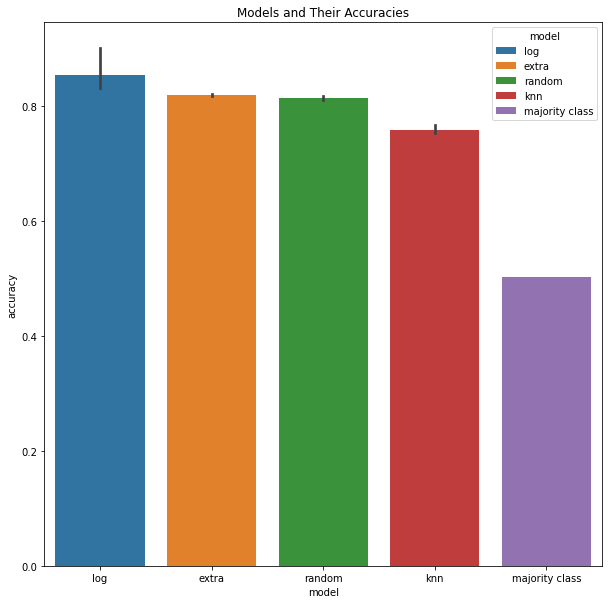

In [22]:
plt.figure(figsize=(10,10))
plt.title('Models and Their Accuracies')
sns.barplot(x=temp['model'], y=temp['accuracy'], hue=temp['model'], dodge=False)

In [17]:
temp = temp.append({'accuracy': 0.503451,
                'model': 'majority class'}, ignore_index=True)